pip install arch

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [25]:
# Import S&P500 data
csvpath = Path('../Resources/GSPC.csv')
sp500 = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-02,740.739990,742.809998,729.549988,737.010010,737.010010,463230000
1997-01-03,737.010010,748.239990,737.010010,748.030029,748.030029,452970000
1997-01-06,748.030029,753.309998,743.820007,747.650024,747.650024,531350000
1997-01-07,747.650024,753.260010,742.179993,753.229980,753.229980,538220000
1997-01-08,753.229980,755.719971,747.710022,748.409973,748.409973,557510000


<AxesSubplot:xlabel='Date'>

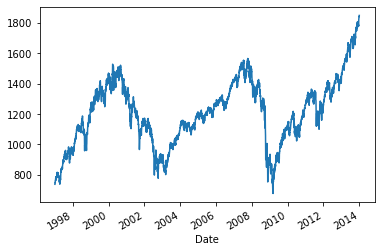

In [26]:
sp500.Close.plot()

<AxesSubplot:xlabel='Date'>

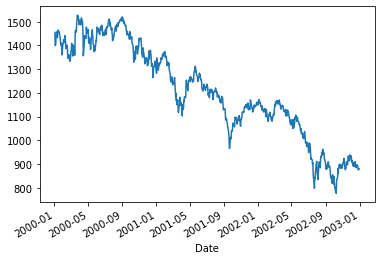

In [27]:
# September 11th attack, bursting of dot-com bubble
sp500.loc['2000':'2002'].Close.plot()

<AxesSubplot:xlabel='Date'>

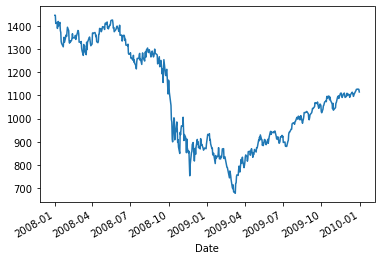

In [28]:
sp500.loc['2008':'2009'].Close.plot()

<AxesSubplot:xlabel='Date'>

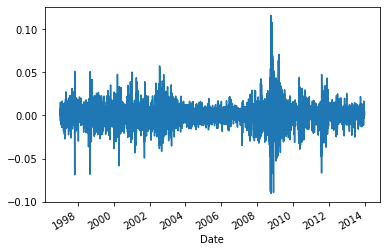

In [29]:
# GARCH assumes stationarity
# Clustering of volatility seen, e.g. 2008-2010
sp500['Close'].pct_change().plot()

In [30]:
# Focus on the 2008-2009 Financial Crisis Period
returns = sp500.loc['2008':'2009'].Close.pct_change() * 100
returns = returns.dropna()
returns.tail()

Date
2009-12-24    0.525617
2009-12-28    0.115408
2009-12-29   -0.140105
2009-12-30    0.019543
2009-12-31   -1.004960
Name: Close, dtype: float64

# GARCH

In [31]:
from arch import arch_model

In [32]:
# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH using a zero mean process model.
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [33]:
# Fit the GARCH Model
res = model.fit(disp="off")

In [34]:
# Summarize the model results
# Looking for Alpha and Beta parameters to have statistically significant p-values
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -991.155
Distribution:                  Normal   AIC:                           1988.31
Method:            Maximum Likelihood   BIC:                           2000.98
                                        No. Observations:                  504
Date:                Mon, Mar 22 2021   Df Residuals:                      504
Time:                        19:03:15   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0255  2.268e-02      1.124      0.261 [-1.895e-02,6.993e-02]
alpha[1]       0.0986  2.185e-02      4.512  6.420e-06    [5.577e-02,  0.141]
beta[1]        0.8968  1.882e-02     47.650      0.000      [  0.860,  0.934]
=============================================================================

Covariance estimator: robust
"""

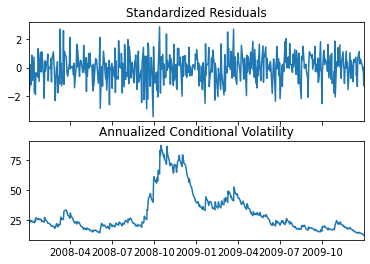

In [35]:
# Plot the model estimate of annualized volatility
# annualize='D' argument reflects a scaling by 252 trading days that are in a year
# Standardized Residuals are the residuals divided by the model estimated volatility, fluctuations should approximate zero.
# Annualized Conditional Volatility shows represents volatility over time.
fig = res.plot(annualize='D')

# Forecasting from GARCH

In [36]:
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 3
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast(start='2009-12-31', horizon=forecast_horizon)

C:\Users\email\Anaconda3\envs\dev\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [21]:
# Annualize the forecast and sqrt
intermediate = np.sqrt(forecasts.variance.dropna()*252)
intermediate

,h.1,h.2,h.3
Date,,,
2009-12-31,13.007879,13.223021,13.43375


# Visualizing the forecast

In [22]:
# The name of the column here is the date of the forecast.
# Each row represents the forecast of volatility for the following days.
# Transposing makes the forecast easier to plot
final = intermediate.dropna().T
final

Date,2009-12-31
h.1,13.007879
h.2,13.223021
h.3,13.433750


<AxesSubplot:>

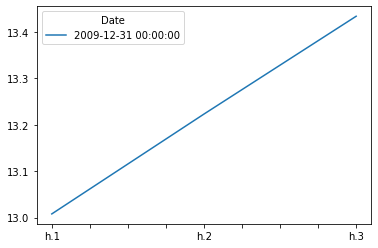

In [23]:
final.plot()